# Nursing Home Staffing Analysis
### **Objective**
This analysis aims to:
- Identify **understaffed facilities** that may need contract nurses.
- Analyze **contractor reliance** and how it varies by state.
- Detect **growth markets** for contract staffing.
- Correlate **staffing shortages** with **contractor reliance**.

### **Data Sources**
- **[PBJ Q1 & Q2 2024](https://data.cms.gov/quality-of-care/payroll-based-journal-daily-nurse-staffing/data)**: Daily staffing data from **CMS Payroll-Based Journal**. (Although the assignment tasked me to use Q2 data, I've included Q1 as well for analyzing trends)
- **[Provider Information](https://data.cms.gov/provider-data/dataset/4pq5-n9py#data-table)**: Includes RNs per Residents, ownership type, location and so on.

### **Key Questions**
1. **Where are nursing homes experiencing staffing shortages?**
2. **Which states/facilities rely most on contract nurses?**
3. **Which states are seeing an increase in contractor usage?**
4. **Is there a correlation between staffing shortages and contractor use?**

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import zipfile
from scipy.stats import pearsonr

### **Data Preprocessing**

1. **Loading Q1 & Q2 2024 PBJ datasets**.

In [96]:
with zipfile.ZipFile('/content/PBJ_Daily_Nurse_Staffing_Q1_2024.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

with zipfile.ZipFile('/content/PBJ_Daily_Nurse_Staffing_Q2_2024.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [97]:
df_Q1 = pd.read_csv("/content/PBJ_Daily_Nurse_Staffing_Q1_2024.csv", dtype={"PROVNUM": str}, encoding="latin-1")
df_Q2 = pd.read_csv("/content/PBJ_Daily_Nurse_Staffing_Q2_2024.csv", dtype={"PROVNUM": str}, encoding="latin-1")

In [98]:
# Add Quarter Identifiers
df_Q1["Quarter"] = "2024Q1"
df_Q2["Quarter"] = "2024Q2"

In [99]:
# Combine Datasets
df_all = pd.concat([df_Q1, df_Q2], ignore_index=True)

2. **Exploratory Data Analysis (EDA)**.

In [100]:
df_all.head()

,PROVNUM,PROVNAME,CITY,STATE,COUNTY_NAME,COUNTY_FIPS,CY_Qtr,WorkDate,MDScensus,Hrs_RNDON,...,Hrs_CNA,Hrs_CNA_emp,Hrs_CNA_ctr,Hrs_NAtrn,Hrs_NAtrn_emp,Hrs_NAtrn_ctr,Hrs_MedAide,Hrs_MedAide_emp,Hrs_MedAide_ctr,Quarter
0,015009,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,Franklin,59,2024Q1,20240101,50,8.0,...,156.34,156.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024Q1
1,015009,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,Franklin,59,2024Q1,20240102,49,8.0,...,149.40,149.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024Q1
2,015009,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,Franklin,59,2024Q1,20240103,49,8.0,...,147.15,147.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024Q1
3,015009,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,Franklin,59,2024Q1,20240104,50,8.0,...,142.21,142.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024Q1
4,015009,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,Franklin,59,2024Q1,20240105,51,8.0,...,149.40,149.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024Q1


In [101]:
df_all.shape

(2656290, 34)

In [102]:
df_all.dtypes

,0
PROVNUM,object
PROVNAME,object
CITY,object
STATE,object
COUNTY_NAME,object
COUNTY_FIPS,int64
CY_Qtr,object
WorkDate,int64
MDScensus,int64
Hrs_RNDON,float64


In [103]:
print(df_all.describe())

        COUNTY_FIPS      WorkDate     MDScensus     Hrs_RNDON  Hrs_RNDON_emp  \
count  2.656290e+06  2.656290e+06  2.656290e+06  2.656290e+06   2.656290e+06   
mean   9.112035e+01  2.024037e+07  8.341938e+01  5.199253e+00   5.104126e+00   
std    9.916513e+01  1.711101e+02  4.908950e+01  4.469814e+00   4.461979e+00   
min    1.000000e+00  2.024010e+07  0.000000e+00  0.000000e+00   0.000000e+00   
25%    3.100000e+01  2.024022e+07  5.100000e+01  0.000000e+00   0.000000e+00   
50%    6.900000e+01  2.024033e+07  7.600000e+01  8.000000e+00   8.000000e+00   
75%    1.170000e+02  2.024052e+07  1.040000e+02  8.000000e+00   8.000000e+00   
max    8.400000e+02  2.024063e+07  7.430000e+02  3.277500e+02   3.277500e+02   

       Hrs_RNDON_ctr   Hrs_RNadmin  Hrs_RNadmin_emp  Hrs_RNadmin_ctr  \
count   2.656290e+06  2.656290e+06     2.656290e+06     2.656290e+06   
mean    9.512693e-02  1.025982e+01     1.001247e+01     2.473507e-01   
std     9.133972e-01  1.480999e+01     1.458400e+01     1.84679

3. **Handling missing values**.

In [104]:
# Handle Missing Values
df_all.fillna(0, inplace=True)

In [105]:
#Check for null values
df_all.isnull().sum()

,0
PROVNUM,0
PROVNAME,0
CITY,0
STATE,0
COUNTY_NAME,0
COUNTY_FIPS,0
CY_Qtr,0
WorkDate,0
MDScensus,0
Hrs_RNDON,0


In [106]:
#Check for Quarter Information Split
df_all['CY_Qtr'].value_counts()

,count
CY_Qtr,
2024Q1,1330966
2024Q2,1325324


4. **Summary**

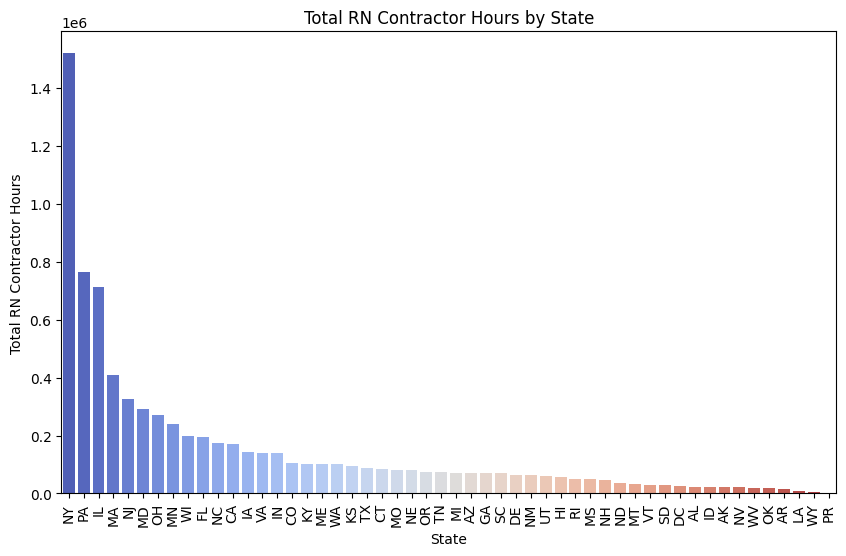

In [107]:
# Contractor Hours by State
total_RN_ctr_hours = df_all.groupby("STATE")["Hrs_RN_ctr"].sum().reset_index()
total_RN_ctr_hours.sort_values(by="Hrs_RN_ctr", ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=total_RN_ctr_hours, x="STATE", y="Hrs_RN_ctr", palette="coolwarm", hue="STATE")
plt.title("Total RN Contractor Hours by State")
plt.xlabel("State")
plt.ylabel("Total RN Contractor Hours")
plt.xticks(rotation=90)
plt.show()

**Key Observation:** The State of New York has the highest RN contract hours. However, from a Sales point of view, this data is not enough to make strategic decisions.

## Staffing Shortages Analysis
### **Why This Matters**
- Facilities with **low staffing-to-resident ratios** may **need contract nurses**.
- We define a facility as **"understaffed"** if **Direct Care Hours per Resident < 3.0**.

[ Note: We only focus on Direct Care (RNs, CNAs and LPNs) for our analysis ]

In [108]:
# Calculate total direct care hours
df_all["Total_Direct_Care_Hours"] = (
    df_all["Hrs_RN_emp"] + df_all["Hrs_RN_ctr"] +
    df_all["Hrs_LPN_emp"] + df_all["Hrs_LPN_ctr"] +
    df_all["Hrs_CNA_emp"] + df_all["Hrs_CNA_ctr"]
)

# Calculate direct care hours per resident
df_all["Direct_Care_Hours_Per_Resident"] = df_all["Total_Direct_Care_Hours"] / df_all["MDScensus"]

In [109]:
provider_df = pd.read_csv("/content/NH_ProviderInfo_Nov2024.csv")

In [110]:
provider_df['Reported Total Nurse Staffing Hours per Resident per Day'].mean()

3.837296291955617

In [111]:
provider_df['Adjusted RN Staffing Hours per Resident per Day'].mean()

0.6700734590801722

In [112]:
# Define Shortage Criteria (Threshold: < 3.0 hours per resident per day)
df_all["Staffing_Shortage"] = df_all["Direct_Care_Hours_Per_Resident"] < 3.83

# Trend of Staffing Shortages Over Time
shortage_trends = df_all.groupby("Quarter")["Staffing_Shortage"].mean().reset_index()
shortage_trends["Staffing_Shortage"] *= 100  # Convert to percentage

In [113]:
# Define Low Staffed Threshold to be the lower quartile
low_staffed_threshold = df_all["Direct_Care_Hours_Per_Resident"].quantile(0.25)

# Filter facilities that fall below the threshold
understaffed_facilities = df_all[df_all["Direct_Care_Hours_Per_Resident"] <= low_staffed_threshold]

# Filter understaffed facilities by state
shortstaffed_states_summary = understaffed_facilities.groupby(["STATE"]).agg(
    mean_direct_care_hours=('Direct_Care_Hours_Per_Resident', 'mean')
).reset_index()


# Sort by most understaffed states
shortstaffed_states_summary = shortstaffed_states_summary.sort_values(by="mean_direct_care_hours", ascending=True)

In [114]:
# Filter understaffed facilities
shortstaffed_facilities_summary = understaffed_facilities.groupby(
    ["PROVNUM","PROVNAME","STATE"]
).agg(
    mean_direct_care_hours=('Direct_Care_Hours_Per_Resident', 'mean')
).reset_index()

# Sort by most understaffed facilities
shortstaffed_facilities_summary = shortstaffed_facilities_summary.sort_values(
    by="mean_direct_care_hours", ascending=True
)

# Exclude Facilities that only employ Regular/Full Time employees
shortstaffed_facilities_summary['LOC'] = shortstaffed_facilities_summary['PROVNAME'] + ', ' + shortstaffed_facilities_summary['STATE']
shortstaffed_facilities_summary = shortstaffed_facilities_summary[shortstaffed_facilities_summary['mean_direct_care_hours']>0]

### **Visualizations**
- **Trend Line:** **Staffing shortages over time** (Q1 vs. Q2 2024).

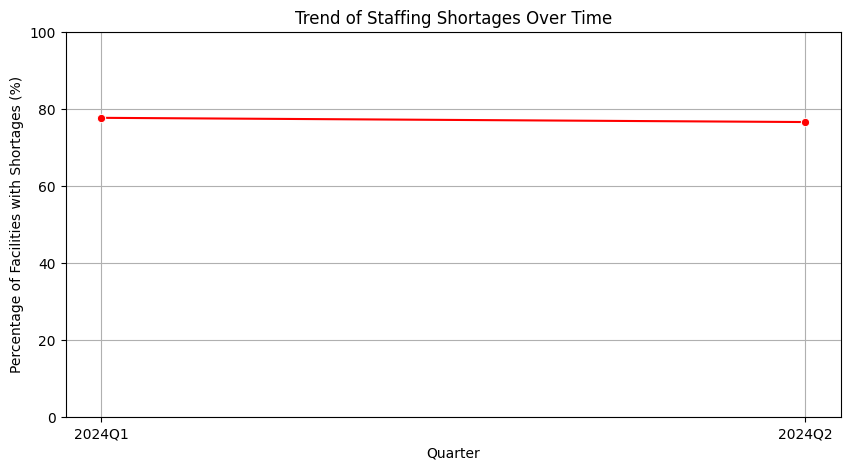

In [115]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Quarter", y="Staffing_Shortage", data=shortage_trends, marker="o", color="red")
plt.title("Trend of Staffing Shortages Over Time")
plt.xlabel("Quarter")
plt.ylabel("Percentage of Facilities with Shortages (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.show()

**Key Observation:** Staffing shortages reduced by a trivial amount from Q1 to Q2 in 2024. This indicates that there is no significant change in the trend.

- **Bar Chart:** Top states with the most **understaffed facilities**.

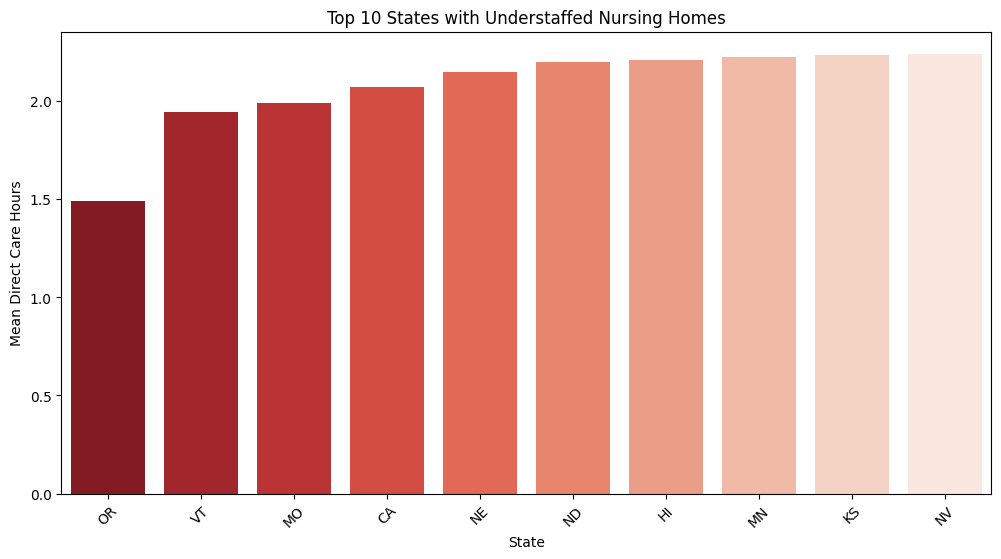

In [116]:
plt.figure(figsize=(12, 6))
sns.barplot(x="STATE", y="mean_direct_care_hours", data=shortstaffed_states_summary.head(10), palette="Reds_r", hue="STATE")
plt.xticks(rotation=45)
plt.xlabel("State")
plt.ylabel("Mean Direct Care Hours")
plt.title("Top 10 States with Understaffed Nursing Homes")
plt.show()

**Key Observation:** Facilities in Oregan have an average of 1.5 mean direct care hours which could indicate that most of them are understaffed.

- **Bar Chart:** Understaffed Nursing Homes

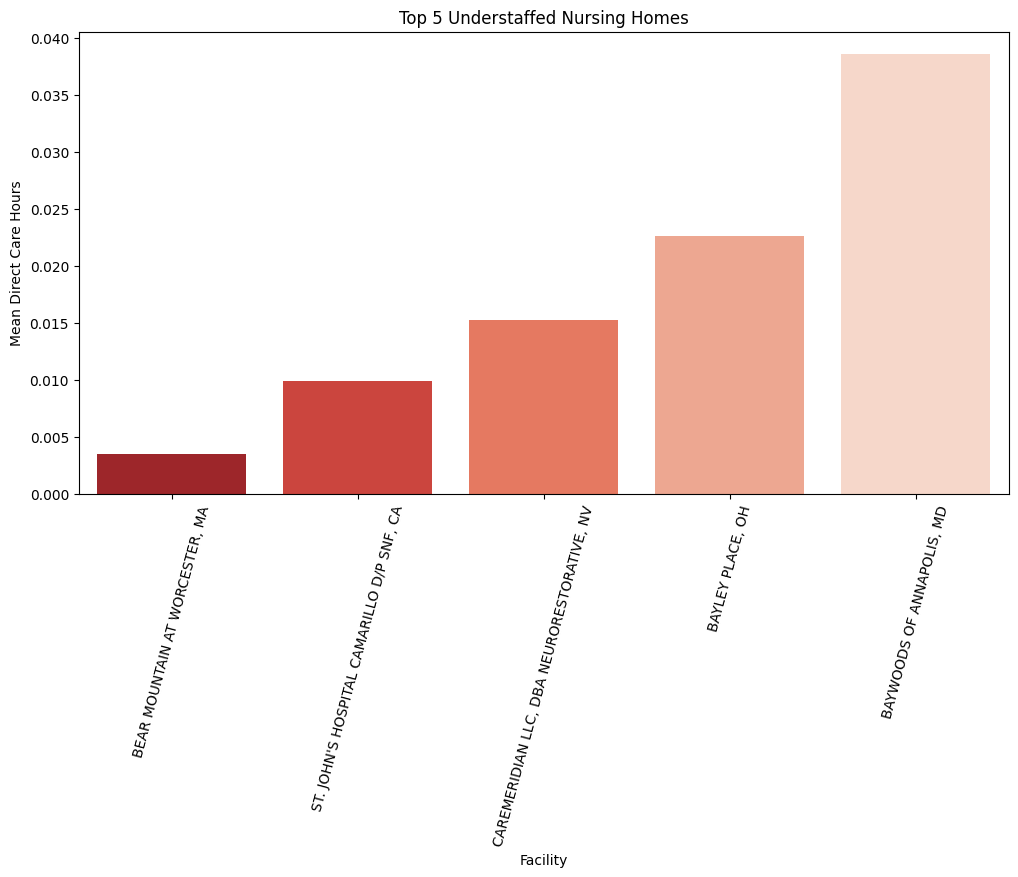

In [117]:
plt.figure(figsize=(12, 6))
sns.barplot(x="LOC", y="mean_direct_care_hours", data=shortstaffed_facilities_summary.head(5), palette="Reds_r", hue="LOC")
plt.xticks(rotation=75)
plt.xlabel("Facility")
plt.ylabel("Mean Direct Care Hours")
plt.title("Top 5 Understaffed Nursing Homes")
plt.show()

**Key Observation:** The above facilities have very less mean direct care hours (indicates that these facilites are shortstaffed) and has 0 contract hours (no contract workers). These facilities potentially demand contract workforce.

## Contractor Staffing Trends
### **Why This Matters**
- Some states rely **more on contract nurses** than others.
- We compare **Direct Care Contractor Ratio** across **states and facilities**.


In [118]:
df_all["Contractor_Hours"] = (
    df_all["Hrs_RN_ctr"] + df_all["Hrs_LPN_ctr"] + df_all["Hrs_CNA_ctr"]
)
df_all["Total_Hours"] = df_all["Total_Direct_Care_Hours"]
df_all["Contractor_Reliance"] = np.where(df_all["Total_Hours"] > 0, df_all["Contractor_Hours"] / df_all["Total_Hours"], 0)


In [119]:
# Contractor Reliance by State
contractor_trends = df_all.groupby("STATE")["Contractor_Reliance"].mean().reset_index()
contractor_trends.sort_values(by="Contractor_Reliance", ascending=False, inplace=True)

In [120]:
contractor_reliance_trends = df_all.groupby("Quarter")["Contractor_Reliance"].mean().reset_index()
contractor_reliance_trends["Contractor_Reliance"] *= 100  # Convert to percentage

In [121]:
df_all["RN_Contractor_Ratio"] = df_all["Hrs_RN_ctr"] / (df_all["Hrs_RN_emp"] + df_all["Hrs_RN_ctr"])
df_all["LPN_Contractor_Ratio"] = df_all["Hrs_LPN_ctr"] / (df_all["Hrs_LPN_emp"] + df_all["Hrs_LPN_ctr"])
df_all["CNA_Contractor_Ratio"] = df_all["Hrs_CNA_ctr"] / (df_all["Hrs_CNA_emp"] + df_all["Hrs_CNA_ctr"])

# Replace NaN (division by zero) with 0
df_all.fillna(0, inplace=True)

contractor_trends_over_time = df_all.groupby(["STATE", "Quarter"])[["RN_Contractor_Ratio", "LPN_Contractor_Ratio", "CNA_Contractor_Ratio"]].mean().reset_index()

# Pivot to see growth trends
pivoted = contractor_trends_over_time.pivot(index="STATE", columns="Quarter", values="RN_Contractor_Ratio")

# Calculate growth from Q1 to Q2
pivoted["Growth"] = pivoted["2024Q2"] - pivoted["2024Q1"]

top_growth_states = pivoted.sort_values(by="Growth", ascending=False).head(5).index.tolist()

# Filter the dataset for these states
growth_trends_filtered = contractor_trends_over_time[contractor_trends_over_time["STATE"].isin(top_growth_states)]


### **Visualizations**
- **Histogram:** Distribution of contractor reliance.

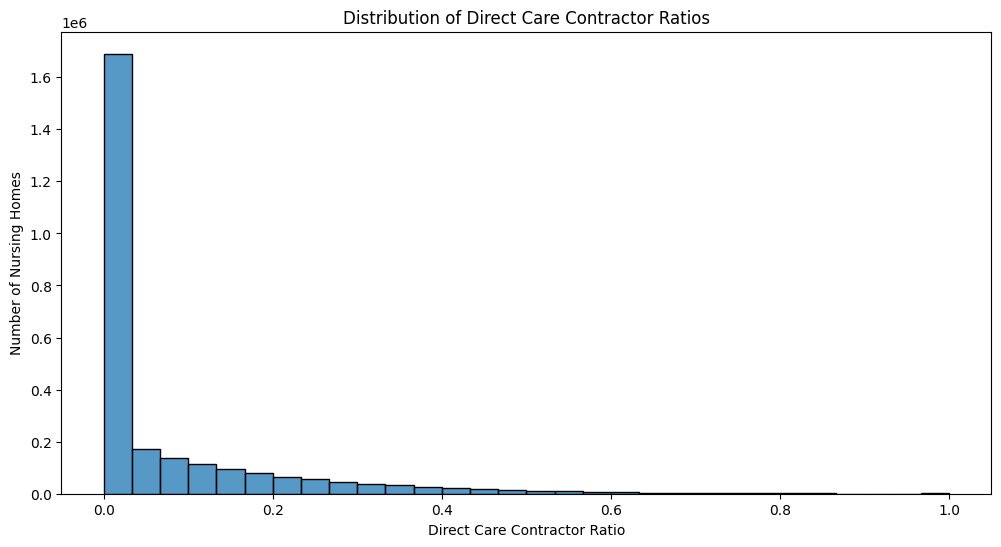

In [122]:
plt.figure(figsize=(12, 6))
sns.histplot(df_all["Contractor_Reliance"], bins=30)
plt.title("Distribution of Direct Care Contractor Ratios")
plt.xlabel("Direct Care Contractor Ratio")
plt.ylabel("Number of Nursing Homes")
plt.show()

**Key Observation:** Direct Care Contract Ratio (Ratio of Contractors with respect to all personnel) in Medical Facilites are skewed betweeen 0 and 0.2. This shows that in almost all medical facilities at most 20% of direct care workforce are hired on a contract basis.

- **Line Plot:** Contractor Reliance Over Time.

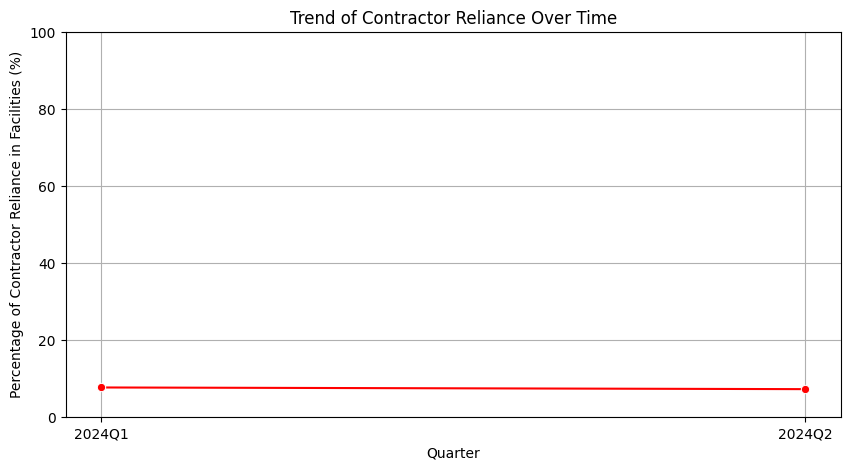

In [123]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Quarter", y="Contractor_Reliance", data=contractor_reliance_trends, marker="o", color="red")
plt.title("Trend of Contractor Reliance Over Time")
plt.xlabel("Quarter")
plt.ylabel("Percentage of Contractor Reliance in Facilities (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.show()

**Key Observation:** No Significant difference is found in contract staffing trends. This could indicate that this trend is seasonal or subject to a larger time period.

- **Bar Chart:** Top states with the highest **contractor reliance**.

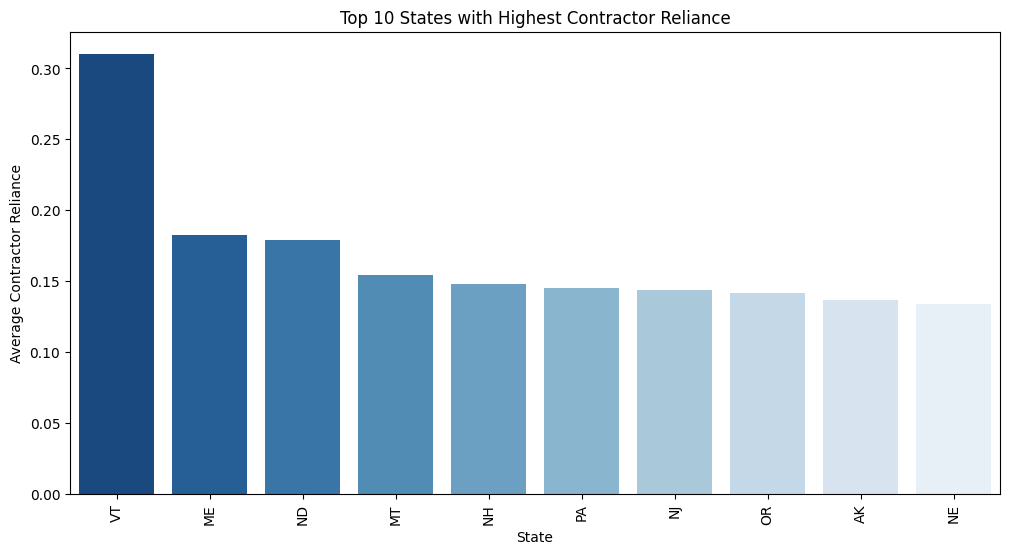

In [124]:
plt.figure(figsize=(12, 6))
sns.barplot(x="STATE", y="Contractor_Reliance", data=contractor_trends.head(10), palette="Blues_r", hue='STATE')
plt.xticks(rotation=90)
plt.title("Top 10 States with Highest Contractor Reliance")
plt.xlabel("State")
plt.ylabel("Average Contractor Reliance")
plt.show()

**Key Observation:** Vermont, Maine and North Dakota are Top 3 states that run facilities where direct care is hired on a contract basis. This indicates a stable need for contract worker demand in these states.

- **Line Plot**: Increase in Contractor Trends per State

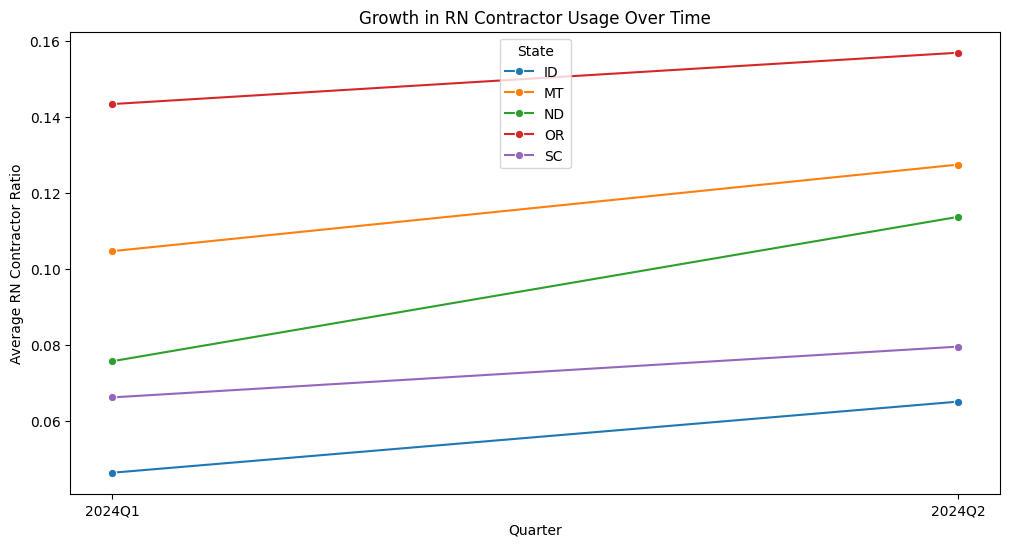

In [125]:
# Line plot of RN contractor ratio over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=growth_trends_filtered, x="Quarter", y="RN_Contractor_Ratio", hue="STATE", marker="o")
plt.xlabel("Quarter")
plt.ylabel("Average RN Contractor Ratio")
plt.title("Growth in RN Contractor Usage Over Time")
plt.legend(title="State")
plt.show()

**Key Observation:** North Dakota, Oregon and Idaho have significant increase in RN contractor trends. These states have markets worth exploring.

## Correlation Analysis


### **Why This Matters**
- Correlations between fields can uncover relationships that can be leveraged to make decisions.
- We compare **Direct Care Contractor Ratio** against **Direct care hours** and also check for synergies between the different contracted staffing hours.

### **Visualizations**
- **Heatmap:** Correlation Matrix for Staffing Hours.

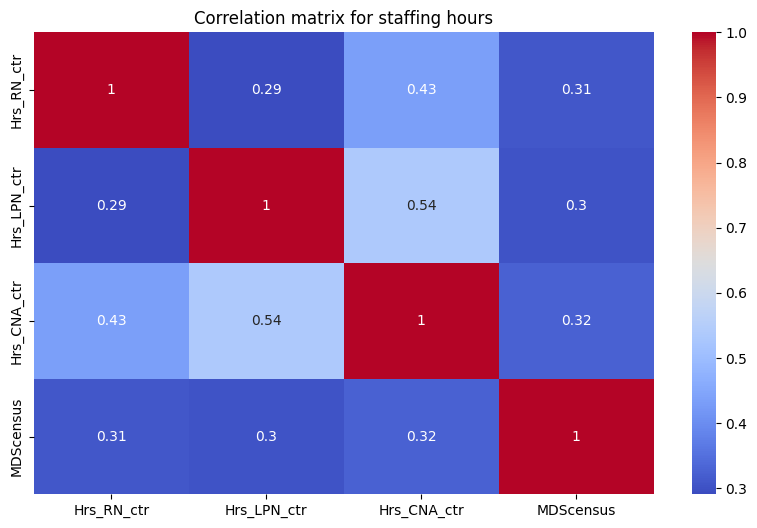

In [126]:
corr_matrix = df_all[['Hrs_RN_ctr','Hrs_LPN_ctr','Hrs_CNA_ctr','MDScensus']].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot = True, cmap='coolwarm')
plt.title("Correlation matrix for staffing hours")
plt.show()

**Key Observation:** There is a moderate correlation between Contract hires for CNAs and LPNs. This indicates that these positions are usually contracted together.

In [127]:
corr_coef, p_value = pearsonr(df_all["Staffing_Shortage"], df_all["Contractor_Reliance"])
print(f"Correlation between Staffing Shortages and Contractor Reliance: {corr_coef:.2f} (p-value: {p_value:.4f})")

Correlation between Staffing Shortages and Contractor Reliance: -0.02 (p-value: 0.0000)


- **Scatter Plot:** Does the number of Direct care hours relate to % of Contractors in facilities

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


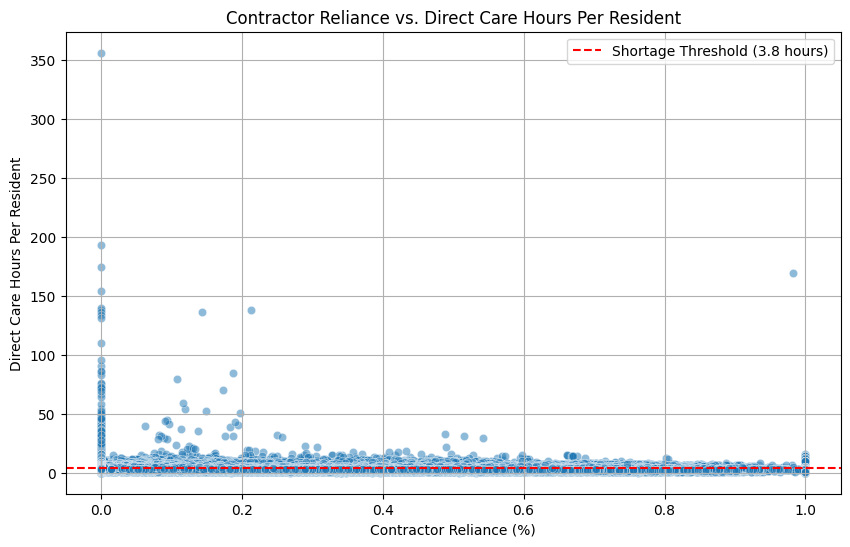

In [129]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_all["Contractor_Reliance"], y=df_all["Direct_Care_Hours_Per_Resident"], alpha=0.5)
plt.axhline(3.8, color="red", linestyle="--", label="Shortage Threshold (3.8 hours)")
plt.title("Contractor Reliance vs. Direct Care Hours Per Resident")
plt.xlabel("Contractor Reliance (%)")
plt.ylabel("Direct Care Hours Per Resident")
plt.legend()
plt.grid(True)
plt.show()

**Key Observation:** The correlation **(-0.02)** suggests **other factors influence contractor hiring**.There is no significant correlation between the number of direct care hours and contractor reliance.

## Key Takeaways
- ### Nursing Homes are facing staffing shortages in Oregon, Vermont and Missouri.
- ### Vermont, North Dakota, Maine etc rely heavily on contract workforce.
- ### North Dakota, Idaho, and Oregon have increasing trends in Contractor staffing.
- ### Staffing Shortage does not affect Contractor Reliance.